<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>May 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

## <span id="section-0" style="color:#00B8DE"> 0 - Imports, Parameters, Functions </span>

In [134]:
import  warnings
import  phitter
import  numpy                                       as      np
import  matplotlib.pyplot                           as      plt
import  statsmodels.api                             as      sm
from    time                                        import  time
from    scipy.stats                                 import  norm, johnsonsu, johnsonsb, lognorm, kstest, anderson, skew, kurtosis
from    scipy.special                               import  eval_genlaguerre
from    sklearn.linear_model                        import  LinearRegression, Ridge
from    math                                        import  sqrt, exp
from    j_johnson_M                                 import  f_johnson_M
from    statsmodels.stats.diagnostic                import  normal_ad
from    statsmodels.nonparametric.kernel_regression import  KernelReg

np.random.seed(0)
plt.style.use('ggplot')

In [135]:
color_jlsmc     = 'blue'
color_glsmc     = 'red'
color_invalid   = 'purple'

In [136]:
# 1/24 = 1 week. 1Y = 6M | 1M = 4W --> 1Y = 24W
# 1/240 = 1/2 bday. 1W = 5 bdays
r, S0, sigma, T, delta, dt = 0.05, 100, 0.3, 1, 1/24, 1/240

time_grid   = np.arange(0, T, dt)
N           = len(time_grid)-1
M           = 200000
tref        = 1/12 # 1/12 : 1 month
ind_tref, ind_delta, ind_tdelta = int(tref/dt), int(delta/dt), int((tref+delta)/dt)
Sref        = 100 # 100
alpha       = 0.99
K           = 95
order_mom   = 4

jtypes_map      = {'SL': 1, 'SU': 2, 'SB': 3, 'SN': 4, 'ST': 5}
rev_jtypes_map  = {v: k for k, v in jtypes_map.items()}

In [137]:
def beta(t):
    return np.exp(-r*t)

def gen_S(S0, M, N):
    paths           = np.zeros((M, N+1))
    paths[:, 0]     = S0
    Z               = np.random.normal(0, 1, size=(M, N))
    increments      = np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    paths[:, 1:]    = S0 * np.cumprod(increments, axis=1)
    return paths

def gen_mtm_put(S_paths, time_grid):
    M   = S_paths.shape[0]
    N   = S_paths.shape[1]-1
    mtm = np.zeros((M, N+1))
    for i in range(N+1):
        d1          = (np.log(S_paths[:, i]/K) + (r + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm[:, i]   = K*beta(T-time_grid[i])*norm.cdf(-d2) - S_paths[:, i]*norm.cdf(-d1)
        
    return mtm

def get_mu2(mu1raw, mu2raw):
    return mu2raw - mu1raw**2
def get_mu3(mu1raw, mu2raw, mu3raw):
    return mu3raw - 3*mu1raw*mu2raw - mu1raw**3
def get_mu4(mu1raw, mu2raw, mu3raw, mu4raw):
    return mu4raw - 4*mu1raw*mu3raw + 6*mu2raw*mu1raw**2 - 3*mu1raw**4
def get_centred_moms(mu1raw, mu2raw, mu3raw, mu4raw):
    mu2 = get_mu2(mu1raw, mu2raw)
    mu3 = get_mu3(mu1raw, mu2raw, mu3raw)
    mu4 = get_mu4(mu1raw, mu2raw, mu3raw, mu4raw)
    return mu2, mu3, mu4
def get_skew(mu3, mu2):
    return mu3 / mu2**(3/2)
def get_kurt(mu4, mu2):
    return mu4 / mu2**2

def regress_moms_jlsmc(mtm_train, y_train, mtm_pred_list):
    S_jlsmc = 2
    X_train = np.column_stack([eval_genlaguerre(s, 0, mtm_train) for s in range(S_jlsmc+1)])
    yhat_pred_list  = []
    X_pred_list     = []
    for mtm in mtm_pred_list:
        X_pred      = np.column_stack([eval_genlaguerre(s, 0, mtm) for s in range(S_jlsmc+1)])
        yhat_pred   = np.zeros((len(mtm), order_mom+1))
        X_pred_list.append(X_pred)
        yhat_pred_list.append(yhat_pred)
    for j in range(1, order_mom+1):
        model = LinearRegression(fit_intercept=False)
        model.fit(X_train, y_train[:, j-1])
        for i, mtm in enumerate(mtm_pred_list):
            yhat_pred_list[i][:, j-1] = model.predict(X_pred_list[i])

    return yhat_pred_list


def regress_moms_glsmc(mtm_train, y_train, mtm_pred_list):
    S_glsmc = 2
    X_train = np.column_stack([mtm_train**s for s in range(S_glsmc+1)])
    model   = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    yhat_pred_list = []
    for mtm in mtm_pred_list:
        X_pred          = np.column_stack([mtm**s for s in range(S_glsmc+1)])
        yhat_pred       = np.zeros((len(mtm), order_mom+1))
        yhat_pred[:, 1] = model.predict(X_pred)
        yhat_pred[:, 3] = 3*yhat_pred[:, 1]**2
        yhat_pred_list.append(yhat_pred)

    return yhat_pred_list


def get_moms_mask(yhat):
    mu1rawhat, mu2rawhat, mu3rawhat, mu4rawhat = yhat[:, 0], yhat[:, 1], yhat[:, 2], yhat[:, 3]
    mu2hat, mu3hat, mu4hat  = get_centred_moms(mu1rawhat, mu2rawhat, mu3rawhat, mu4rawhat)
    skewhat                 = get_skew(mu3hat, mu2hat)
    kurthat                 = get_kurt(mu4hat, mu2hat)

    mask_mu2hat     = (mu2rawhat>0)&(mu2hat>0)
    mask_mu3hat     = (mu2rawhat>0)
    mask_mu4hat     = (mu4rawhat>0)&(mu2rawhat>0)&(mu4hat>0)
    mask_skewhat    = (mask_mu3hat)&(mask_mu2hat)
    mask_kurthat    = (mask_mu4hat)&(mask_mu2hat)
    mask_tothat     = (mask_skewhat)&(mask_kurthat)
    
    return mu1rawhat, mu2rawhat, mu3rawhat, mu4rawhat, mu2hat, mu3hat, mu4hat, skewhat, kurthat, mask_mu2hat, mask_mu3hat, mask_mu4hat, mask_skewhat, mask_kurthat, mask_tothat


def fit_johnson(mu1rawhat, mu2hat, skewhat, kurthat, mask_tothat):
    jparamshat = np.zeros((len(mu1rawhat), 4))
    jtypehat   = np.zeros(len(mu1rawhat))
    mask_hat_jlsmc = np.zeros_like(mu1rawhat, dtype=bool)
    for i in range(len(mu1rawhat)):
        if mask_tothat[i]:
            jcoeffs, jf, mess = f_johnson_M(mu1rawhat[i], sqrt(mu2hat[i]), skewhat[i], kurthat[i])
            if mess == '(b2 < b1+two)':
                print(f'Warning: impossible region for support point n°{i}')
                jparamshat[i]  = np.repeat(np.nan, 4)
                jtypehat[i]    = None
            else:
                if np.any(np.isnan(jcoeffs)):
                    print(f'Warning: NaN coefficients for support point n°{i}')
                    print(f'    (gamma, delta, xi, lambda)  = ({jcoeffs[0]:.2f}, {jcoeffs[1]:.2f}, {jcoeffs[2]:.2f}, {jcoeffs[3]:.2f})')
                    print(f'    Johnson curve type          = {jtypehat}')
                    print(f'    (mu1, mu2, skew, kurt)      = ({mu1rawhat[i]:.2f}, {mu2hat[i]:.2f}, {skewhat[i]:.2f}, {kurthat[i]:.2f})')
                    jparamshat[i] = np.repeat(np.nan, 4)
                    jtypehat[i]    = None
                else:
                    mask_hat_jlsmc[i] = True
                    jparamshat[i] = jcoeffs
                    jtypehat[i]   = jtypes_map[jf]
    return jparamshat, jtypehat, mask_hat_jlsmc


def quantile_johnson(jparamshat, jtypehat, alpha, mtmdiff_pdf=None):
    quanthat = np.zeros((jparamshat.shape[0], len(alpha)))
    if mtmdiff_pdf is not None:
        pdfhat = np.zeros((len(quanthat), len(mtmdiff_pdf)))
    for i in range(jparamshat.shape[0]):
        if jtypehat[i] == 1:
            quanthat[i]     = lognorm.ppf(alpha, s=1/jparamshat[i:i+1, 1], loc=jparamshat[i:i+1, 2], scale=exp(-jparamshat[i:i+1, 0]/jparamshat[i:i+1, 1]))
            if mtmdiff_pdf is not None:
                pdfhat[i, :] = lognorm.pdf(mtmdiff_pdf, s=1/jparamshat[i, 1], loc=jparamshat[i, 2], scale=exp(-jparamshat[i, 0]/jparamshat[i, 1]))
        elif jtypehat[i] == 2:
            quanthat[i] = johnsonsu.ppf(alpha, a=jparamshat[i:i+1, 0], b=jparamshat[i:i+1, 1], loc=jparamshat[i:i+1, 2], scale=jparamshat[i:i+1, 3])
            if mtmdiff_pdf is not None:
                pdfhat[i, :] = johnsonsu.pdf(mtmdiff_pdf, a=jparamshat[i, 0], b=jparamshat[i, 1], loc=jparamshat[i, 2], scale=jparamshat[i, 3])
        elif (jtypehat[i]==3) or (jtypehat[i]==5):
            quanthat[i] = johnsonsb.ppf(alpha, a=jparamshat[i:i+1, 0], b=jparamshat[i:i+1, 1], loc=jparamshat[i:i+1, 2], scale=jparamshat[i:i+1, 3])
            if mtmdiff_pdf is not None:
                pdfhat[i, :] = johnsonsb.pdf(mtmdiff_pdf, a=jparamshat[i, 0], b=jparamshat[i, 1], loc=jparamshat[i, 2], scale=jparamshat[i, 3])
        elif jtypehat[i] == 4:
            quanthat[i] = norm.ppf(alpha, loc=jparamshat[i:i+1, 2], scale=jparamshat[i:i+1, 3])
            if mtmdiff_pdf is not None:
                pdfhat[i, :] = norm.pdf(mtmdiff_pdf, loc=jparamshat[i, 2], scale=jparamshat[i, 3])
    if mtmdiff_pdf is not None:
        return quanthat, pdfhat
    return quanthat


def quantile_gaussian(mu2hat, alpha, mtmdiff_pdf=None):
    quanthat  = norm.ppf(alpha, loc=0, scale=np.sqrt(mu2hat.reshape(-1, 1)))
    if mtmdiff_pdf is not None:
        pdfhat = norm.pdf(mtmdiff_pdf, loc=0, scale=np.sqrt(mu2hat.reshape(-1, 1)))
        return quanthat, pdfhat
    return quanthat


def get_var_jlsmc(R, mtm_supp, quanthat_supp, mtm_pred_list):
    X_train = np.column_stack([eval_genlaguerre(r, 0, mtm_supp) for r in range(R+1)])
    model   = LinearRegression(fit_intercept=False)
    model.fit(X_train, quanthat_supp)
    yhat_pred_list  = []
    for i, mtm in enumerate(mtm_pred_list):
        X_pred = np.column_stack([eval_genlaguerre(r, 0, mtm) for r in range(R+1)])
        yhat_pred_list.append(model.predict(X_pred))

    return yhat_pred_list


def get_moms_nmc(M, M_in, S):
    S_paths_nested      = np.zeros((M, M_in, ind_tdelta-ind_tref+1))
    mtm_paths_nested    = np.zeros((M, M_in, ind_tdelta-ind_tref+1))
    mtmdiff            = np.zeros((M, M_in))
    for m in range(M):
        S_paths_nested[m, :, :]     = gen_S(S[m], M_in, ind_tdelta-ind_tref)
        mtm_paths_nested[m, :, :]   = gen_mtm_put(S_paths_nested[m, :, :], time_grid[ind_tref:ind_tdelta+1])
        mtmdiff[m, :]               = mtm_paths_nested[m, :, -1] - mtm_paths_nested[m, :, 0]
    
    mu1raw = np.mean(mtmdiff, axis=1)
    mu2raw = np.mean(mtmdiff**2, axis=1)
    mu3raw = np.mean(mtmdiff**3, axis=1)
    mu4raw = np.mean(mtmdiff**4, axis=1)
    mu2, mu3, mu4 = get_mu2(mu1raw, mu2raw), get_mu3(mu1raw, mu2raw, mu3raw), get_mu4(mu1raw, mu2raw, mu3raw, mu4raw)
    skew     = get_skew(mu3, mu2)
    kurt     = get_kurt(mu4, mu2)

    return mtm_paths_nested, mtmdiff, mu1raw, mu2raw, mu3raw, mu4raw, mu2, mu3, mu4, skew, kurt


def gen_var_put(S, mtm):
    var_S   = S * exp((r-0.5*sigma**2)*delta + sigma*sqrt(delta)*norm.ppf(1-alpha))
    temp    = gen_mtm_put(var_S.reshape(-1, 1), time_grid[ind_tdelta:ind_tdelta+1]).reshape(-1)
    varhat  = temp - mtm
    return varhat

## <span id="section-1" style="color:#00B8DE"> I - Risk Factors & Portfolio Paths </span>

In [138]:
S_paths         = gen_S(S0, M, N)
mtm_paths       = gen_mtm_put(S_paths, time_grid)
mtmdiff_paths  = mtm_paths[:, ind_delta:] - mtm_paths[:, :-ind_delta]
mtm_train       = mtm_paths[:, ind_tref]

mtm_ref         = gen_mtm_put(np.array([[Sref]]), time_grid[ind_tref:ind_tref+1])[0]

mtm_func        = np.linspace(np.min(mtm_train), np.max(mtm_train), 1000)

Nq          = 100
Nqtail      = int(0.1*Nq)//2
q_main      = np.arange(1, Nq) / Nq
q_ltail     = np.linspace(0, 0.01, Nqtail+2)[1:-1]
q_utail     = np.linspace(0.99, 1, Nqtail+2)[1:-1]
q_all       = np.sort(np.unique(np.concatenate([q_ltail, q_main, q_utail])))
mtm_supp    = np.quantile(mtm_train, q_all, method='inverted_cdf')

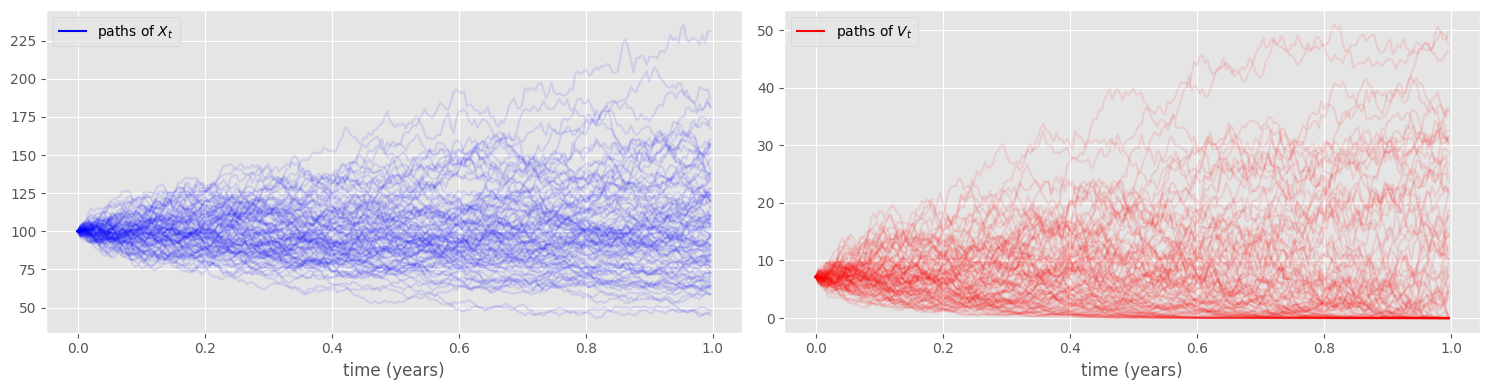

In [139]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(time_grid, S_paths[:100, :].T, color='blue', alpha=0.1)
axs[0].plot([None], [None], color='blue', label='paths of $X_t$')
axs[0].set_xlabel('time (years)')
axs[0].legend(loc='upper left')

axs[1].plot(time_grid, mtm_paths[:100, :].T, color='red', alpha=0.1)
axs[1].plot([None], [None], color='red', label='paths of $V_t$')
axs[1].set_xlabel('time (years)')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

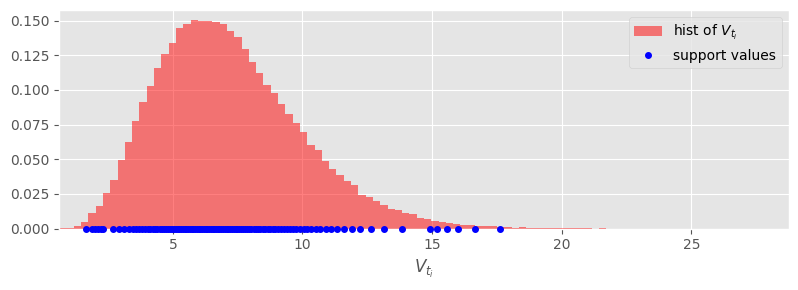

In [140]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(mtm_train, bins=100, density=True, alpha=0.5, color='red', label='hist of $V_{t_i}$')
ax.plot(mtm_supp, np.zeros_like(mtm_supp), 'o', color=color_jlsmc, label='support values', clip_on=False, zorder=10, markersize=4)
ax.set_xlabel('$V_{t_i}$')
ax.set_xlim(np.min(mtm_train), np.max(mtm_train))
ax.legend()
plt.tight_layout()
#plt.savefig(f'figures/quantiles_selec.png', bbox_inches='tight', dpi=300)
plt.show()

In [141]:
Mtest       = 100
Mtest_in    = 100000
S_test      = np.linspace(np.min(S_paths[:, ind_tref]), np.max(S_paths[:, ind_tref]), Mtest)
mtm_test_paths_nested, mtmdiff_test, mu1raw_test, mu2raw_test, mu3raw_test, mu4raw_test, mu2_test, mu3_test, mu4_test, skew_test, kurt_test = get_moms_nmc(Mtest, Mtest_in, S_test)
mtm_test    = mtm_test_paths_nested[:, 0, 0]

Mref_in     = 100000
mtm_ref_paths_nested, mtmdiff_ref, mu1raw_ref, mu2raw_ref, mu3raw_ref, mu4raw_ref, mu2_ref, mu3_ref, mu4_ref, skew_ref, kurt_ref = get_moms_nmc(1, Mref_in, np.array([Sref]))
quant_ref   = np.quantile(mtmdiff_ref[0, :], alpha, method='inverted_cdf')

Mcomp       = 100
Mcomp_in    = 100000
bin_size    = M//Mcomp
sorted_inds = np.argsort(mtm_train)
selec_inds  = np.array([sorted_inds[i*bin_size + bin_size//2] for i in range(Mcomp)])
S_comp      = S_paths[selec_inds, ind_tref]
mtm_comp_paths_nested, mtmdiff_comp, mu1raw_comp, mu2raw_comp, mu3raw_comp, mu4raw_comp, mu2_comp, mu3_comp, mu4_comp, skew_comp, kurt_comp = get_moms_nmc(Mcomp, Mcomp_in, S_comp)
mtm_comp     = mtm_comp_paths_nested[:, 0, 0]
quant_comp   = np.quantile(mtmdiff_comp, alpha, method='inverted_cdf', axis=1)

## <span id="section-2" style="color:#00B8DE"> II - Moments Regression </span>

In [142]:
mtm_pred_list_jlsmc = [mtm_test, mtm_func, mtm_supp, mtm_ref]
mtm_pred_list_glsmc = [mtm_test, mtm_func, mtm_ref, mtm_comp]
y_train_jlsmc = mtmdiff_paths[:, ind_tref:ind_tref+1]**np.arange(1, order_mom+1)
y_train_glsmc = mtmdiff_paths[:, ind_tref]**2

yhat_pred_list_jlsmc = regress_moms_jlsmc(mtm_train, y_train_jlsmc, mtm_pred_list_jlsmc)
yhat_pred_list_glsmc = regress_moms_glsmc(mtm_train, y_train_glsmc, mtm_pred_list_glsmc)

mu1rawhat_test_jlsmc, mu2rawhat_test_jlsmc, mu3rawhat_test_jlsmc, mu4rawhat_test_jlsmc, mu2hat_test_jlsmc, mu3hat_test_jlsmc, mu4hat_test_jlsmc, skewhat_test_jlsmc, kurthat_test_jlsmc, mask_mu2hat_test_jlsmc, mask_mu3hat_test_jlsmc, mask_mu4hat_test_jlsmc, mask_skewhat_test_jlsmc, mask_kurthat_test_jlsmc, mask_tothat_test_jlsmc = get_moms_mask(yhat_pred_list_jlsmc[0])
mu1rawhat_func_jlsmc, mu2rawhat_func_jlsmc, mu3rawhat_func_jlsmc, mu4rawhat_func_jlsmc, mu2hat_func_jlsmc, mu3hat_func_jlsmc, mu4hat_func_jlsmc, skewhat_func_jlsmc, kurthat_func_jlsmc, mask_mu2hat_func_jlsmc, mask_mu3hat_func_jlsmc, mask_mu4hat_func_jlsmc, mask_skewhat_func_jlsmc, mask_kurthat_func_jlsmc, mask_tothat_func_jlsmc = get_moms_mask(yhat_pred_list_jlsmc[1])
mu1rawhat_supp_jlsmc, mu2rawhat_supp_jlsmc, mu3rawhat_supp_jlsmc, mu4rawhat_supp_jlsmc, mu2hat_supp_jlsmc, mu3hat_supp_jlsmc, mu4hat_supp_jlsmc, skewhat_supp_jlsmc, kurthat_supp_jlsmc, mask_mu2hat_supp_jlsmc, mask_mu3hat_supp_jlsmc, mask_mu4hat_supp_jlsmc, mask_skewhat_supp_jlsmc, mask_kurthat_supp_jlsmc, mask_tothat_supp_jlsmc = get_moms_mask(yhat_pred_list_jlsmc[2])
mu1rawhat_ref_jlsmc, mu2rawhat_ref_jlsmc, mu3rawhat_ref_jlsmc, mu4rawhat_ref_jlsmc, mu2hat_ref_jlsmc, mu3hat_ref_jlsmc, mu4hat_ref_jlsmc, skewhat_ref_jlsmc, kurthat_ref_jlsmc, mask_mu2hat_ref_jlsmc, mask_mu3hat_ref_jlsmc, mask_mu4hat_ref_jlsmc, mask_skewhat_ref_jlsmc, mask_kurthat_ref_jlsmc, mask_tothat_ref_jlsmc                = get_moms_mask(yhat_pred_list_jlsmc[3])
mu1rawhat_test_glsmc, mu2rawhat_test_glsmc, mu3rawhat_test_glsmc, mu4rawhat_test_glsmc, mu2hat_test_glsmc, mu3hat_test_glsmc, mu4hat_test_glsmc, skewhat_test_glsmc, kurthat_test_glsmc, mask_mu2hat_test_glsmc, mask_mu3hat_test_glsmc, mask_mu4hat_test_glsmc, mask_skewhat_test_glsmc, mask_kurthat_test_glsmc, mask_tothat_test_glsmc = get_moms_mask(yhat_pred_list_glsmc[0])
mu1rawhat_func_glsmc, mu2rawhat_func_glsmc, mu3rawhat_func_glsmc, mu4rawhat_func_glsmc, mu2hat_func_glsmc, mu3hat_func_glsmc, mu4hat_func_glsmc, skewhat_func_glsmc, kurthat_func_glsmc, mask_mu2hat_func_glsmc, mask_mu3hat_func_glsmc, mask_mu4hat_func_glsmc, mask_skewhat_func_glsmc, mask_kurthat_func_glsmc, mask_tothat_func_glsmc = get_moms_mask(yhat_pred_list_glsmc[1])
mu1rawhat_ref_glsmc, mu2rawhat_ref_glsmc, mu3rawhat_ref_glsmc, mu4rawhat_ref_glsmc, mu2hat_ref_glsmc, mu3hat_ref_glsmc, mu4hat_ref_glsmc, skewhat_ref_glsmc, kurthat_ref_glsmc, mask_mu2hat_ref_glsmc, mask_mu3hat_ref_glsmc, mask_mu4hat_ref_glsmc, mask_skewhat_ref_glsmc, mask_kurthat_ref_glsmc, mask_tothat_ref_glsmc                = get_moms_mask(yhat_pred_list_glsmc[2])
mu1rawhat_comp_glsmc, mu2rawhat_comp_glsmc, mu3rawhat_comp_glsmc, mu4rawhat_comp_glsmc, mu2hat_comp_glsmc, mu3hat_comp_glsmc, mu4hat_comp_glsmc, skewhat_comp_glsmc, kurthat_comp_glsmc, mask_mu2hat_comp_glsmc, mask_mu3hat_comp_glsmc, mask_mu4hat_comp_glsmc, mask_skewhat_comp_glsmc, mask_kurthat_comp_glsmc, mask_tothat_comp_glsmc = get_moms_mask(yhat_pred_list_glsmc[3])

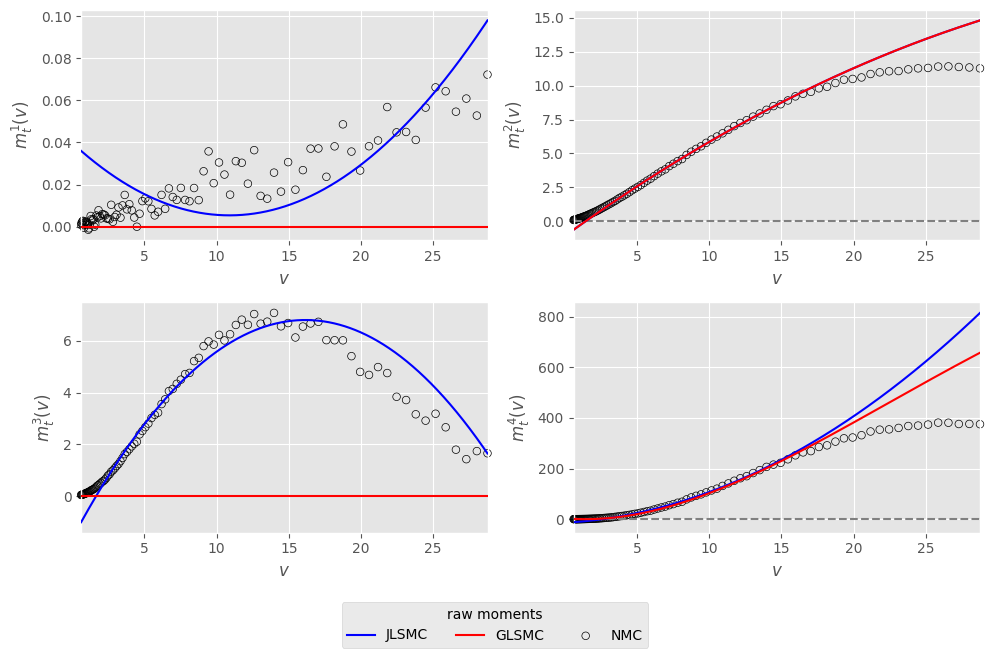

In [143]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].plot(mtm_func, mu1rawhat_func_jlsmc, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0, 0].plot(mtm_func, mu1rawhat_func_glsmc, color=color_glsmc, label='GLSMC', zorder=3)
axs[0, 0].scatter(mtm_test, mu1raw_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0, 0].set_xlabel('$v$')
axs[0, 0].set_ylabel('$m_t^1(v)$')
axs[0, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[0, 1].plot(mtm_func, mu2rawhat_func_jlsmc, color=color_jlsmc, zorder=3)
axs[0, 1].plot(mtm_func, mu2rawhat_func_glsmc, color=color_glsmc, zorder=3)
axs[0, 1].scatter(mtm_test, mu2raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[0, 1].axhline(0, color='grey', linestyle='--')
axs[0, 1].set_xlabel('$v$')
axs[0, 1].set_ylabel('$m_t^2(v)$')
axs[0, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 0].plot(mtm_func, mu3rawhat_func_jlsmc, color=color_jlsmc, zorder=3)
axs[1, 0].plot(mtm_func, mu3rawhat_func_glsmc, color=color_glsmc, zorder=3)
axs[1, 0].scatter(mtm_test, mu3raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 0].set_xlabel('$v$')
axs[1, 0].set_ylabel('$m_t^3(v)$')
axs[1, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 1].plot(mtm_func, mu4rawhat_func_jlsmc, color=color_jlsmc, zorder=3)
axs[1, 1].plot(mtm_func, mu4rawhat_func_glsmc, color=color_glsmc, zorder=3)
axs[1, 1].scatter(mtm_test, mu4raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 1].axhline(0, color='grey', linestyle='--')
axs[1, 1].set_xlabel('$v$')
axs[1, 1].set_ylabel('$m_t^4(v)$')
axs[1, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='raw moments')

plt.tight_layout()
plt.show()

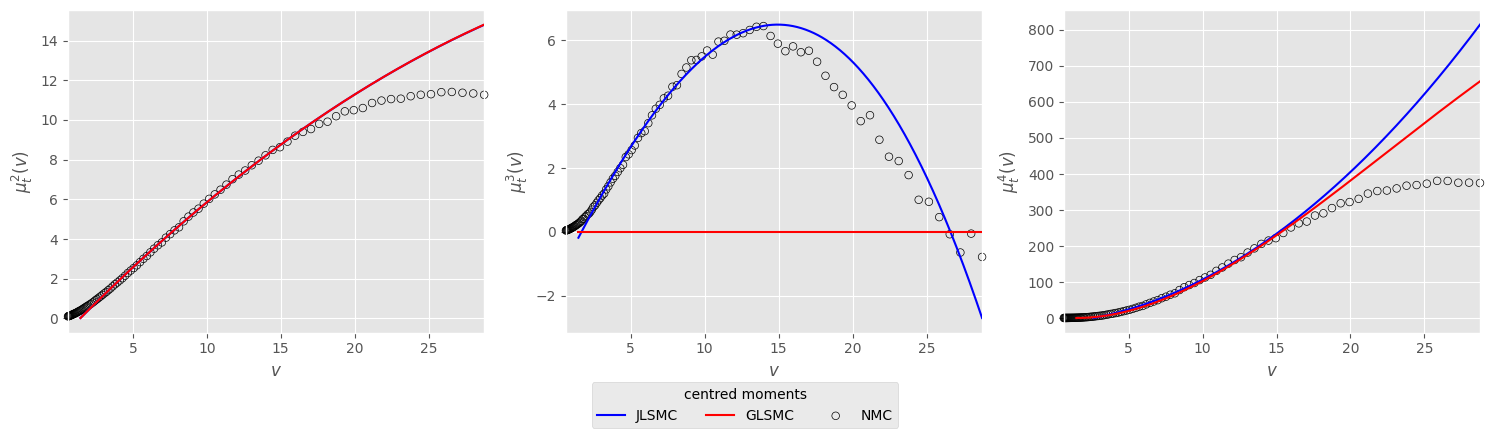

In [144]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(mtm_func[mask_mu2hat_func_jlsmc], mu2hat_func_jlsmc[mask_mu2hat_func_jlsmc], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].plot(mtm_func[mask_mu2hat_func_glsmc], mu2hat_func_glsmc[mask_mu2hat_func_glsmc], color=color_glsmc, label='GLSMC', zorder=3)
axs[0].scatter(mtm_test, mu2_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\mu_t^2(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1].plot(mtm_func[mask_mu3hat_func_jlsmc], mu3hat_func_jlsmc[mask_mu3hat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].plot(mtm_func[mask_mu3hat_func_glsmc], mu3hat_func_glsmc[mask_mu3hat_func_glsmc], color=color_glsmc, zorder=3)
axs[1].scatter(mtm_test, mu3_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\mu_t^3(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[2].plot(mtm_func[mask_mu4hat_func_jlsmc], mu4hat_func_jlsmc[mask_mu4hat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[2].plot(mtm_func[mask_mu4hat_func_glsmc], mu4hat_func_glsmc[mask_mu4hat_func_glsmc], color=color_glsmc, zorder=3)
axs[2].scatter(mtm_test, mu4_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[2].set_xlabel('$v$')
axs[2].set_ylabel('$\\mu_t^4(v)$')
axs[2].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='centred moments')

plt.tight_layout()
plt.show()

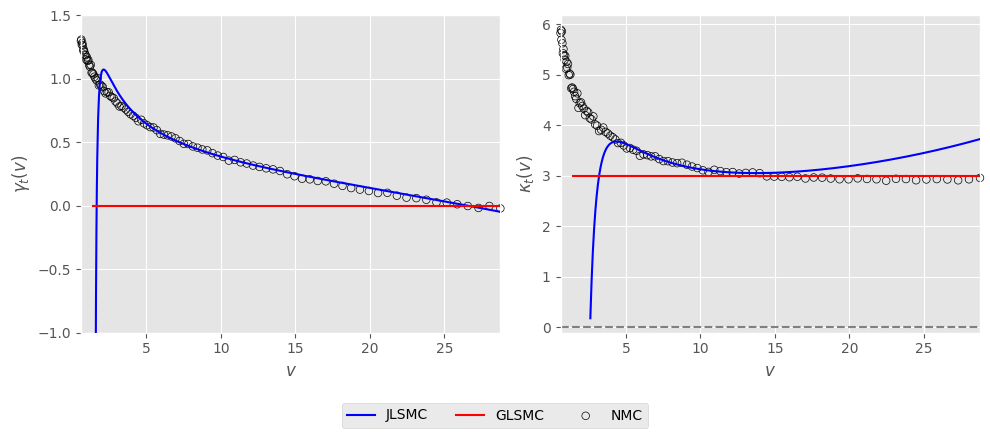

In [145]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mtm_func[mask_skewhat_func_jlsmc], skewhat_func_jlsmc[mask_skewhat_func_jlsmc], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].plot(mtm_func[mask_skewhat_func_glsmc], skewhat_func_glsmc[mask_skewhat_func_glsmc], color=color_glsmc, label='GLSMC', zorder=3)
axs[0].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\gamma_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[0].set_ylim(bottom=-1, top=1.5)

axs[1].plot(mtm_func[mask_kurthat_func_jlsmc], kurthat_func_jlsmc[mask_kurthat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].plot(mtm_func[mask_kurthat_func_glsmc], kurthat_func_glsmc[mask_kurthat_func_glsmc], color=color_glsmc, zorder=3)
axs[1].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].axhline(0, color='grey', linestyle='--')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\kappa_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

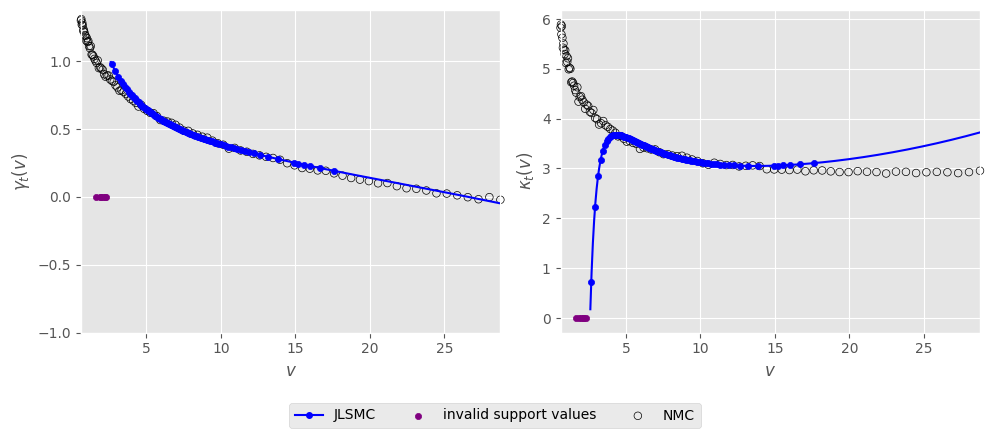

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mtm_func[mask_tothat_func_jlsmc], skewhat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[mask_tothat_supp_jlsmc], skewhat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\gamma_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[0].set_ylim(bottom=-1)

axs[1].plot(mtm_func[mask_tothat_func_jlsmc], kurthat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[1].scatter(mtm_supp[mask_tothat_supp_jlsmc], kurthat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[1].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\kappa_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

## <span id="section-3" style="color:#00B8DE"> III - Johnson Moment Fitting </span>

In [147]:
warnings.filterwarnings('ignore')

jparamshat_supp, jtypehat_supp, mask_hat_supp_jlsmc   = fit_johnson(mu1rawhat_supp_jlsmc, mu2hat_supp_jlsmc, skewhat_supp_jlsmc, kurthat_supp_jlsmc, mask_tothat_supp_jlsmc)
jparamshat_ref, jtypehat_ref, mask_hat_ref_jlsmc      = fit_johnson(mu1rawhat_ref_jlsmc, mu2hat_ref_jlsmc, skewhat_ref_jlsmc, kurthat_ref_jlsmc, mask_tothat_ref_jlsmc)

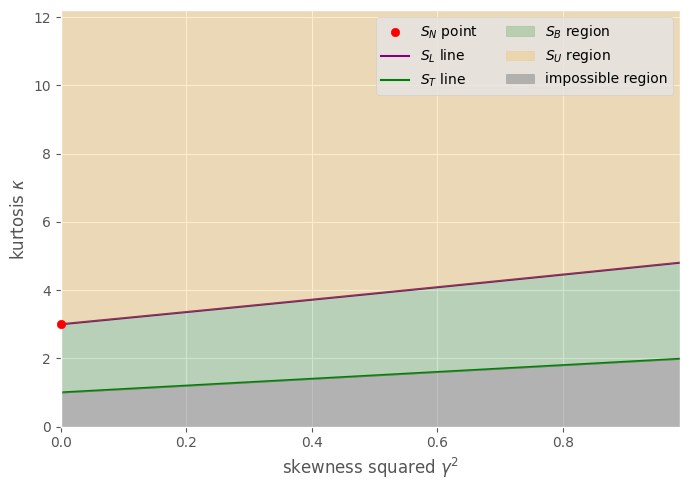

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter([0], [3], color=color_glsmc, label='$S_N$ point', zorder=3, clip_on=False)

omega       = np.linspace(1, 1.4, 100)
beta1_sl    = (omega-1) * (omega+2)**2
kurt_sl     = omega**4 + 2*omega**3 + 3*omega**2 - 3
ax.plot(beta1_sl, kurt_sl, color='purple', label='$S_L$ line', zorder=1)
kurt_lim    = 1 + beta1_sl
ax.plot(beta1_sl, kurt_lim, color='green', label='$S_T$ line', zorder=1)
ax.fill_between(beta1_sl, kurt_lim, kurt_sl, color='green', alpha=0.2, label='$S_B$ region', zorder=1)

max_kurt = max(np.max(kurthat_func_jlsmc[mask_tothat_func_jlsmc]), np.max(kurthat_func_glsmc[mask_tothat_func_jlsmc]), np.max(kurt_sl), np.max(kurt_lim))
ax.fill_between(beta1_sl, kurt_sl, max_kurt*np.ones_like(kurt_sl), color='orange', alpha=0.2, label='$S_U$ region', zorder=1)
beta1_lim   = np.linspace(np.min(skewhat_func_jlsmc[mask_tothat_func_jlsmc]**2), np.max(skewhat_func_jlsmc[mask_tothat_func_jlsmc]**2), 100)
kurt_lim2   = 1 + beta1_lim
ax.fill_between(beta1_lim, kurt_lim2, np.zeros_like(kurt_lim2), color='grey', alpha=0.5, label='impossible region', zorder=1)

ax.set_xlabel('skewness squared $\\gamma^2$')
ax.set_ylabel('kurtosis $\\kappa$')
ax.set_xlim(0, np.max(beta1_lim))
ax.set_ylim(0, max_kurt)
ax.legend(ncol=2)
plt.tight_layout()
#plt.savefig(f'figures/johnson_curve.png', bbox_inches='tight', dpi=300)
plt.show()

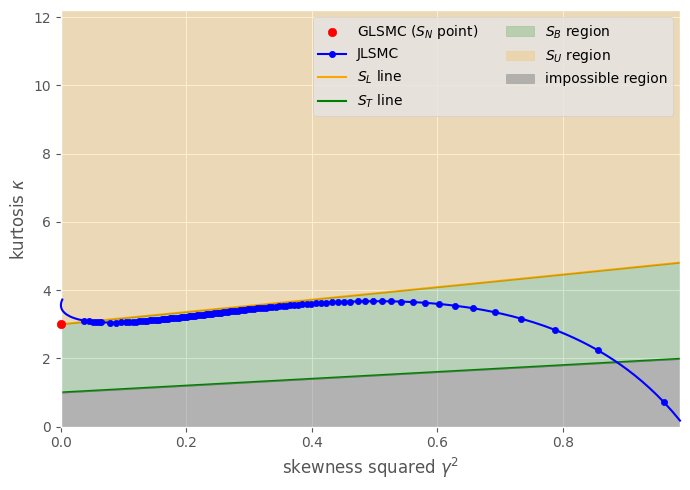

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter([0], [3], color=color_glsmc, label='GLSMC ($S_N$ point)', zorder=3, clip_on=False)
ax.plot(skewhat_func_jlsmc[mask_tothat_func_jlsmc]**2, kurthat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3, clip_on=False)
ax.scatter(skewhat_supp_jlsmc[mask_tothat_supp_jlsmc]**2, kurthat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3, clip_on=False)
ax.plot([None], [None], color=color_jlsmc, marker='o', markersize=4, label='JLSMC')
ax.plot(beta1_sl, kurt_sl, color='orange', label='$S_L$ line', zorder=1)
ax.plot(beta1_sl, kurt_lim, color='green', label='$S_T$ line', zorder=1)
ax.fill_between(beta1_sl, kurt_lim, kurt_sl, color='green', alpha=0.2, label='$S_B$ region', zorder=1)
ax.fill_between(beta1_sl, kurt_sl, max_kurt*np.ones_like(kurt_sl), color='orange', alpha=0.2, label='$S_U$ region', zorder=1)
ax.fill_between(beta1_lim, kurt_lim2, np.zeros_like(kurt_lim2), color='grey', alpha=0.5, label='impossible region', zorder=1)

ax.set_xlabel('skewness squared $\\gamma^2$')
ax.set_ylabel('kurtosis $\\kappa$')
ax.set_xlim(0, np.max(beta1_lim))
ax.set_ylim(0, max_kurt)
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

## <span id="section-4" style="color:#00B8DE"> IV - Value-at-Risk Regression </span>

In [150]:
print(f'Number of invalid support points: {np.sum(~mask_hat_supp_jlsmc)}')

jparamshat_supp, jtypehat_supp, mtm_supp = jparamshat_supp[mask_hat_supp_jlsmc], jtypehat_supp[mask_hat_supp_jlsmc], mtm_supp[mask_hat_supp_jlsmc]
jparamshat_ref, jtypehat_ref, mtm_ref    = jparamshat_ref[mask_hat_ref_jlsmc], jtypehat_ref[mask_hat_ref_jlsmc], mtm_ref[mask_hat_ref_jlsmc]

quanthat_supp_jlsmc = quantile_johnson(jparamshat_supp, jtypehat_supp, np.array([alpha]))
mtmdiff_pdf_ref = np.linspace(np.min(mtmdiff_ref), np.max(mtmdiff_ref), 1000)
quanthat_ref_jlsmc, pdfhat_ref_jlsmc = quantile_johnson(jparamshat_ref, jtypehat_ref, np.array([alpha]), mtmdiff_pdf_ref)
quanthat_ref_glsmc, pdfhat_ref_glsmc = quantile_gaussian(mu2hat_ref_glsmc, alpha, mtmdiff_pdf_ref)

Number of invalid support points: 7


In [151]:
R_jlsmc                 = 2
varhat_pred_list_jlsmc  = get_var_jlsmc(R_jlsmc, mtm_supp, quanthat_supp_jlsmc, [mtm_func, mtm_comp])
varhat_func_jlsmc       = varhat_pred_list_jlsmc[0]
varhat_comp_jlsmc      = varhat_pred_list_jlsmc[1]

Rbis_jlsmc                  = 4
varhatbis_pred_list_jlsmc   = get_var_jlsmc(Rbis_jlsmc, mtm_supp, quanthat_supp_jlsmc, [mtm_func, mtm_comp])
varhatbis_func_jlsmc        = varhatbis_pred_list_jlsmc[0]
varhatbis_comp_jlsmc        = varhatbis_pred_list_jlsmc[1]

varhat_func_glsmc   = quantile_gaussian(mu2hat_func_glsmc[mask_mu2hat_func_glsmc], alpha)
varhat_comp_glsmc  = quantile_gaussian(mu2hat_comp_glsmc[mask_mu2hat_comp_glsmc], alpha)
var_test            = gen_var_put(S_test, mtm_test)

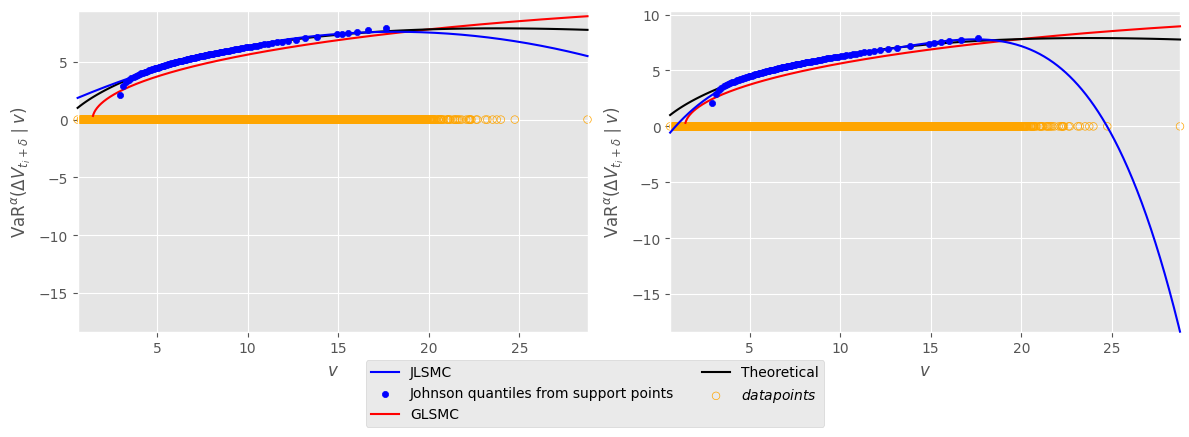

In [152]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(mtm_func, varhat_func_jlsmc, color=color_jlsmc, zorder=4, clip_on=False, label='JLSMC')
axs[0].scatter(mtm_supp, quanthat_supp_jlsmc, color=color_jlsmc, s=20, zorder=5, clip_on=False, label='Johnson quantiles from support points')
axs[0].plot(mtm_func[mask_mu2hat_func_glsmc], varhat_func_glsmc, color=color_glsmc, label='GLSMC', zorder=3, clip_on=False)
axs[0].plot(mtm_test, var_test, color='black', label='Theoretical', zorder=3, clip_on=False)
axs[0].scatter(mtm_train, np.zeros_like(mtm_train), color='orange', s=30, zorder=1, clip_on=False, facecolors='none', label='$data points$')
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\text{VaR}^\\alpha(\\Delta V_{t_i+\\delta} \\mid v)$')
axs[0].set_xlim(np.min(mtm_test), np.max(mtm_test))
axs[0].set_ylim(bottom=np.min(varhatbis_func_jlsmc))

axs[1].plot(mtm_func, varhatbis_func_jlsmc, color=color_jlsmc, zorder=4, clip_on=False, label='JLSMC')
axs[1].scatter(mtm_supp, quanthat_supp_jlsmc, color=color_jlsmc, s=20, zorder=5, clip_on=False, label='johnson support quantiles')
axs[1].plot(mtm_func[mask_mu2hat_func_glsmc], varhat_func_glsmc, color=color_glsmc, label='GLSMC', zorder=3, clip_on=False)
axs[1].plot(mtm_test, var_test, color='black', label='theoretical', zorder=3, clip_on=False)
axs[1].scatter(mtm_train, np.zeros_like(mtm_train), color='orange', s=30, zorder=1, clip_on=False, facecolors='none', label='$data points$')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\text{VaR}^\\alpha(\\Delta V_{t_i+\\delta} \\mid v)$')
axs[1].set_xlim(np.min(mtm_test), np.max(mtm_test))
axs[1].set_ylim(bottom=np.min(varhatbis_func_jlsmc))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
# plt.savefig(f'figures/results12.png', bbox_inches='tight', dpi=300)
plt.show()

In [153]:
mse_jlsmc   = np.mean((varhat_comp_jlsmc - quant_comp)**2) / np.mean((quant_comp)**2)
print(f'normalized MSE JLSMC        : {mse_jlsmc:.4f}')
mse_glsmc   = np.mean((varhat_comp_glsmc - quant_comp)**2) / np.mean((quant_comp)**2)
print(f'normalized MSE GLSMC        : {mse_glsmc:.4f}')
ratio_mse   = mse_glsmc / mse_jlsmc
print(f'ratio MSE GLSMC vs JLSMC    : {ratio_mse:.4f}')

normalized MSE JLSMC        : 0.0777
normalized MSE GLSMC        : 0.0962
ratio MSE GLSMC vs JLSMC    : 1.2382


## <span id="section-4" style="color:#00B8DE"> V - Additional Statistical Verifications </span>

In [154]:
alpha_qq                = np.linspace(0.001, 0.999, 1000)
qq_quanthat_ref_jlsmc   = quantile_johnson(jparamshat_ref, jtypehat_ref, alpha_qq)
qq_quanthat_ref_glsmc   = quantile_gaussian(mu2hat_ref_glsmc, alpha_qq)

In [155]:
pvalad_ref      = normal_ad(mtmdiff_ref[0])[1]
pvalhat_ksn_ref = kstest(mtmdiff_ref[0], 'norm', args=(0, np.sqrt(mu2hat_ref_glsmc[0]))).pvalue


print(f'pval AD (normal): {pvalad_ref:.4%}')
print(f'pval KS (normal): {pvalhat_ksn_ref:.4%}')

pval AD (normal): 0.0000%
pval KS (normal): 0.0000%


In [156]:
jparams_ref, jtype_ref, _   = f_johnson_M(mu1raw_ref[0], np.sqrt(mu2_ref[0]), skew_ref[0], kurt_ref[0])
jtype_ref = jtypes_map[jtype_ref]
if jtype_ref == 1:
    jparams_ref_mle = lognorm.fit(mtmdiff_ref[0])
elif jtype_ref == 2:
    jparams_ref_mle = johnsonsu.fit(mtmdiff_ref[0])
elif (jtypehat_ref==3) or (jtypehat_ref==5):
    jparams_ref_mle = johnsonsb.fit(mtmdiff_ref[0])
elif jtypehat_ref == 4:
    jparams_ref_mle = norm.fit(mtmdiff_ref[0])

print(f'Johnson params from nested MC moments and MLE   ({rev_jtypes_map[jtype_ref]}) : ({jparams_ref_mle[0]:.2f}, {jparams_ref_mle[1]:.2f}, {jparams_ref_mle[2]:.2f}, {jparams_ref_mle[3]:.2f})')
print(f'Johnson params from nested MC moments and MM    ({rev_jtypes_map[jtype_ref]}) : ({jparams_ref[0]:.2f}, {jparams_ref[1]:.2f}, {jparams_ref[2]:.2f}, {jparams_ref[3]:.2f})')
print(f'Jhonson params from regressed moments and MM    ({rev_jtypes_map[jtypehat_ref[0]]}) : ({jparamshat_ref[0, 0]:.2f}, {jparamshat_ref[0, 1]:.2f}, {jparamshat_ref[0, 2]:.2f}, {jparamshat_ref[0, 3]:.2f})')

Johnson params from nested MC moments and MLE   (SB) : (0.66, 1.22, -5.76, 16.94)
Johnson params from nested MC moments and MM    (SB) : (4.37, 3.19, -7.90, 38.16)
Jhonson params from regressed moments and MM    (SB) : (5.38, 3.55, -8.55, 46.58)


In [157]:
def pval_ks_johnson(mtm, jparams, jtype):
    if jtype == 1:
        return kstest(mtm, 'lognorm', args=(1/jparams[1], jparams[2], exp(-jparams[0]/jparams[1]))).pvalue
    elif jtype == 2:
        return kstest(mtm, 'johnsonsu', args=(jparams[0], jparams[1], jparams[2], jparams[3])).pvalue
    elif (jtype==3) or (jtype==5):
        return kstest(mtm, 'johnsonsb', args=(jparams[0], jparams[1], jparams[2], jparams[3])).pvalue
    elif jtype == 4:
        return kstest(mtm, 'norm', args=(jparams[2], jparams[3])).pvalue
    
pvalhat_ksj_ref     = pval_ks_johnson(mtmdiff_ref[0], jparamshat_ref[0], jtypehat_ref[0])
pval_ksj_ref        = pval_ks_johnson(mtmdiff_ref[0], jparams_ref, jtype_ref)
pval_ksj_ref_mle    = pval_ks_johnson(mtmdiff_ref[0], jparams_ref_mle, jtype_ref)

print(f'pval KS from nested MC moments and MLE  ({rev_jtypes_map[jtype_ref]}) : {(pval_ksj_ref_mle):.2%}')
print(f'pval KS from nested MC moments and MM   ({rev_jtypes_map[jtype_ref]}) : {(pval_ksj_ref):.2%}')
print(f'pval KS from regressed moments and MM   ({rev_jtypes_map[jtypehat_ref[0]]}) : {(pvalhat_ksj_ref):.2%}')

pval KS from nested MC moments and MLE  (SB) : 0.00%
pval KS from nested MC moments and MM   (SB) : 67.29%
pval KS from regressed moments and MM   (SB) : 33.30%


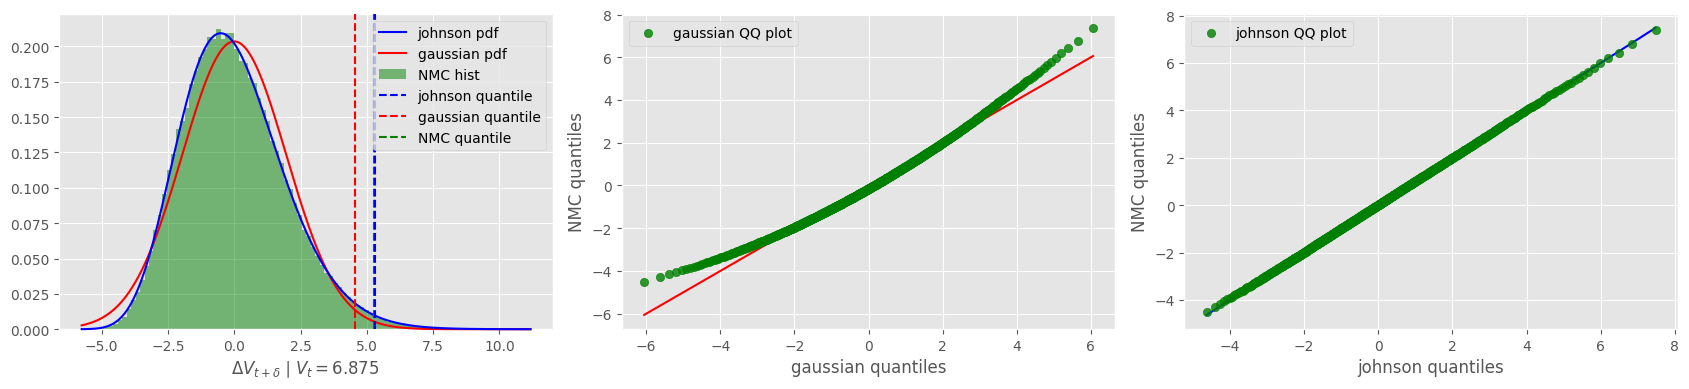

In [158]:
fig, axs = plt.subplots(1, 3, figsize=(17, 4))

axs[0].plot(mtmdiff_pdf_ref, pdfhat_ref_jlsmc[0], color=color_jlsmc, label='johnson pdf', zorder=4, clip_on=False)
axs[0].plot(mtmdiff_pdf_ref, pdfhat_ref_glsmc[0], color=color_glsmc, label='gaussian pdf', zorder=3, clip_on=False)
axs[0].hist(mtmdiff_ref[0], bins=100, density=True, color='green', alpha=0.5, label='NMC hist', zorder=1, clip_on=False)

axs[0].axvline(x=quanthat_ref_jlsmc, color=color_jlsmc, linestyle='--', label='johnson quantile', zorder=5, clip_on=False)
axs[0].axvline(x=quanthat_ref_glsmc, color=color_glsmc, linestyle='--', label='gaussian quantile', zorder=5, clip_on=False)
axs[0].axvline(x=quant_ref, color='green', linestyle='--', label='NMC quantile', zorder=4, clip_on=False)
axs[0].set_xlabel('$\\Delta V_{t+\\delta} \\mid V_t = 6.875$ ')
axs[0].legend()

axs[1].plot(qq_quanthat_ref_glsmc[0], qq_quanthat_ref_glsmc[0], color=color_glsmc, zorder=3, clip_on=False)
axs[1].scatter(qq_quanthat_ref_glsmc[0], np.quantile(mtmdiff_ref[0], alpha_qq, method='inverted_cdf'), color='green', label='gaussian QQ plot', alpha=0.8, zorder=3, clip_on=False)
axs[1].set_xlabel('gaussian quantiles')
axs[1].set_ylabel('NMC quantiles')
axs[1].legend()

axs[2].plot(qq_quanthat_ref_jlsmc[0], qq_quanthat_ref_jlsmc[0], color=color_jlsmc, zorder=3, clip_on=False)
axs[2].scatter(qq_quanthat_ref_jlsmc[0], np.quantile(mtmdiff_ref[0], alpha_qq, method='inverted_cdf'), color='green', label='johnson QQ plot', alpha=0.8, zorder=3, clip_on=False)
axs[2].set_xlabel('johnson quantiles')
axs[2].set_ylabel('NMC quantiles')
axs[2].legend()

plt.tight_layout()
# plt.savefig(f'figures/distribution_glsmc.png', bbox_inches='tight', dpi=300)
plt.show()

In [159]:
phitter_cont = phitter.Phitter(mtmdiff_ref[0])
phitter_cont.fit()
df = phitter_cont.df_sorted_distributions_sse
df.head(5)

distribution passed       sse  \
                                          
0                 beta      ✅  0.000015   
1             gamma_3p      ✅  0.000026   
2        chi_square_3p      ✅  0.000027   
3  inverse_gaussian_3p      ✅  0.000051   
4         fatigue_life      ✅  0.000067   

                                      parameters     chi_square  \
                                                 test_statistic   
0  alpha: 9.98, beta: 89.41, A: -6.509, B: 58.52      12.669895   
1        alpha: 14.48, loc: -7.402, beta: 0.5126      31.578179   
2          df: 28.51, loc: -7.344, scale: 0.2583      28.799512   
3          mu: 11.13, lambda: 362.8, loc: -11.11      68.110897   
4       gamma: 0.1882, loc: -10.32, scale: 10.16      53.147784   

                                        kolmogorov_smirnov                 \
  critical_value       p_value rejected     test_statistic critical_value   
0      31.410433  8.910940e-01    False           0.001773       0.004293   
1      32.670573  6.455926e-02    False           0.002777       0.004293   
2      32.670573  1.188986e-01    False           0.002858       0.004293   
3      32.670573  7.034504e-07     True           0.003653       0.004293   
4      32.670573  1.309807e-04     True           0.004005       0.004293   

                     anderson_darling                                    
    p_value rejected   test_statistic critical_value   p_value rejected  
0  0.911228    False         0.258926       2.492235  0.965482    False  
1  0.422743    False         0.868766       2.492235  0.433993    False  
2  0.386743    False         0.804581       2.492235  0.477750    False  
3  0.138343    False         2.342838       2.492235  0.059963    False  
4  0.080703    False         2.371969       2.492235  0.057866    False